# Feed-forward neural network

<img src="ff_nn.jpeg">

Давайте вспомним, что такое нейронные сети прямого распространения. 

Нейронные сети прямого распространения (feed forward neural networks, FF или FFNN) и перцептроны (perceptrons, P) очень прямолинейны, они передают информацию от входа к выходу. Нейронные сети часто описываются в виде слоёного торта, где каждый слой состоит из входных, скрытых или выходных клеток. Клетки одного слоя не связаны между собой, а соседние слои обычно полностью связаны. Самая простая нейронная сеть имеет две входных клетки и одну выходную, и может использоваться в качестве модели логических вентилей. FFNN обычно обучается по методу обратного распространения ошибки, в котором сеть получает множества входных и выходных данных. Этот процесс называется обучением с учителем, и он отличается от обучения без учителя тем, что во втором случае множество выходных данных сеть составляет самостоятельно. Вышеупомянутая ошибка является разницей между вводом и выводом. Если у сети есть достаточное количество скрытых нейронов, она теоретически способна смоделировать взаимодействие между входным и выходными данными. Практически такие сети используются редко, но их часто комбинируют с другими типами для получения новых.

По сути - это последовательность матричных умножений

К выходу сети применяется функция активации

<img src="activations.png">

In [1]:
import torch
import numpy as np

from torch import nn
import torchvision

In [2]:
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(1,1)
        print(self.fc)
        self.relu = nn.ReLU()

    def forward(self, x):
        print(x)
        output = self.fc(x)
        print(output)
        output = self.relu(output)
        print(output)
        return output

In [3]:
perc = Perceptron()
print(perc)

Linear(in_features=1, out_features=1, bias=True)
Perceptron(
  (fc): Linear(in_features=1, out_features=1, bias=True)
  (relu): ReLU()
)


In [4]:
# Так выглядит инференс нейронной сети по входным данным
perc(torch.FloatTensor([5])), perc(torch.FloatTensor([-15]))

tensor([5.])
tensor([-2.7548], grad_fn=<ViewBackward0>)
tensor([0.], grad_fn=<ReluBackward0>)
tensor([-15.])
tensor([7.2833], grad_fn=<ViewBackward0>)
tensor([7.2833], grad_fn=<ReluBackward0>)


(tensor([0.], grad_fn=<ReluBackward0>),
 tensor([7.2833], grad_fn=<ReluBackward0>))

In [5]:
perc.fc.weight, perc.fc.bias

(Parameter containing:
 tensor([[-0.5019]], requires_grad=True),
 Parameter containing:
 tensor([-0.2452], requires_grad=True))

# Посмотрим на более сложную архитектуру

In [6]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [7]:
import torch.nn.functional as F

In [8]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        x = self.fc(x)
        if activation=="relu":
            return F.relu(x)
        if activation=="sigmoid":
            return F.sigmoid(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        self.fc1 = Perceptron(input_dim, hidden_dim)
        self.fc2 = Perceptron(hidden_dim, 1, "sigmoid")
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        print(x)
        return x

In [9]:
from sklearn.datasets import make_blobs

def blob_label(y, label, loc): # assign labels
    target = np.copy(y)
    for l in loc:
        target[y == l] = label
    return target

x_train, y_train = make_blobs(n_samples=40, n_features=2, cluster_std=1.5, shuffle=True)
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(blob_label(y_train, 0, [0]))
y_train = torch.FloatTensor(blob_label(y_train, 1, [1,2,3]))

x_test, y_test = make_blobs(n_samples=10, n_features=2, cluster_std=1.5, shuffle=True)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(blob_label(y_test, 0, [0]))
y_test = torch.FloatTensor(blob_label(y_test, 1, [1,2,3]))

In [10]:
import matplotlib.pyplot as plt

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


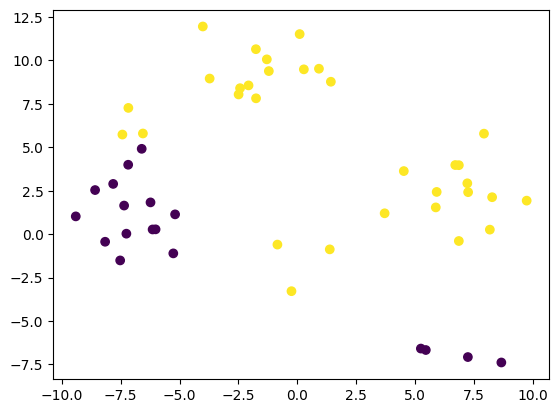

In [11]:
plt.scatter(x_train.numpy()[:, 0], x_train.numpy()[:, 1], c=y_train.numpy())
plt.scatter(x_test.numpy()[:, 0], x_test.numpy()[:, 1], c=(2+y_test.numpy()))

In [12]:
model = Feedforward(2, 10)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [13]:
model.eval()
y_pred = model(x_test)
before_train = criterion(y_pred.squeeze(), y_test)
print('Test loss before training' , before_train.item())

Test loss before training 0.5751269459724426


In [14]:
model.train()
epochs = 20
for epoch in range(epochs):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
   
    print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

Epoch 0: train loss: 0.8446324467658997
Epoch 1: train loss: 0.7827361822128296
Epoch 2: train loss: 0.7278035879135132
Epoch 3: train loss: 0.6788617372512817
Epoch 4: train loss: 0.6350317597389221
Epoch 5: train loss: 0.5956489443778992
Epoch 6: train loss: 0.5600327253341675
Epoch 7: train loss: 0.527851939201355
Epoch 8: train loss: 0.4985544681549072
Epoch 9: train loss: 0.4718872010707855
Epoch 10: train loss: 0.44756636023521423
Epoch 11: train loss: 0.4253389239311218
Epoch 12: train loss: 0.40499329566955566
Epoch 13: train loss: 0.3863219618797302
Epoch 14: train loss: 0.3691050112247467
Epoch 15: train loss: 0.35318613052368164
Epoch 16: train loss: 0.3384355902671814
Epoch 17: train loss: 0.3247641921043396
Epoch 18: train loss: 0.31205591559410095
Epoch 19: train loss: 0.3002023994922638


In [15]:
model.eval()
y_pred = model(x_test)
after_train = criterion(y_pred.squeeze(), y_test) 
print('Test loss after Training' , after_train.item())

Test loss after Training 0.7910116314888


In [16]:
from torch import optim

In [17]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt ### воспользуемся для отображения изображения

In [18]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print (image.size())
print (label)

100%|██████████| 170498071/170498071 [00:48<00:00, 3494525.59it/s]


Extracting data/cifar-10-python.tar.gz to data/
torch.Size([3, 32, 32])
6


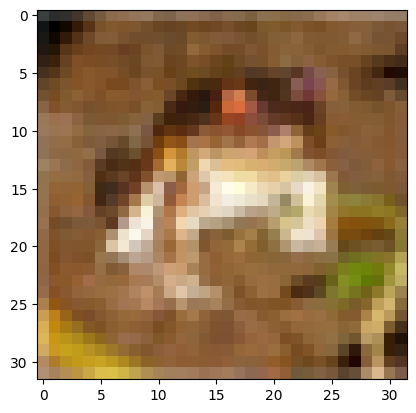

In [19]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [20]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [21]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

Files already downloaded and verified


In [22]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

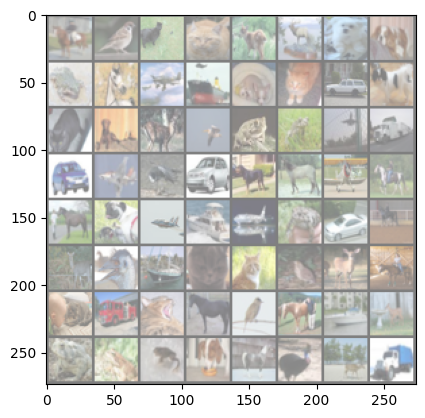

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels

In [43]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim, 2 * hidden_dim, output_dim) #add
        self.pool = nn.MaxPool2d(2, 2) #add
        self.conv2 = nn.Conv2d(2 * hidden_dim, 16, output_dim) #add

        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc4(x)
        #x = F.softmax(x)
        return x


net = Net(3072, 100, 10)

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [45]:
from tqdm import tqdm

In [46]:
for epoch in tqdm(range(10)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x16 and 3072x400)

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Покажем изображение из тестового набора для ознакомления.

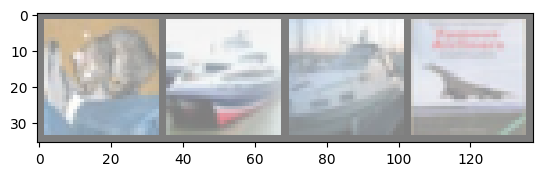

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Хорошо, посмотрим, что думает нейронная сеть в приведенных выше примерах:

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


Результаты кажутся довольно хорошими.
Посмотрим, как сеть работает со всем набором данных.

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 43 %


первоначальная точность 43% неочень хороший результат, надо улучшить
посмотрим какие классы показали хорошие результаты, а какие — не очень

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 45.4 %
Accuracy for class: car   is 70.9 %
Accuracy for class: bird  is 14.0 %
Accuracy for class: cat   is 35.0 %
Accuracy for class: deer  is 24.7 %
Accuracy for class: dog   is 32.8 %
Accuracy for class: frog  is 55.3 %
Accuracy for class: horse is 51.6 %
Accuracy for class: ship  is 67.6 %
Accuracy for class: truck is 37.3 %


Accuracy for class: bird  is 14.0 %
Accuracy for class: cat   is 35.0 %
Accuracy for class: deer  is 24.7 %
Accuracy for class: dog   is 32.8 %
худшие. Добавлю несколько слоев и поменяю функцию активации

Штош, cuda ядер видимо на моем ноуте нету и как запустить на GPU не совсем понятно

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu
